In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**IMPORT DATA**

In [ ]:
import csv
import os
import pandas as pd
import string
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
import shutil
from tensorflow.keras.optimizers import RMSprop
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from google.colab import files
import splitfolders
from sklearn.model_selection import train_test_split
from PIL import Image

**UPLOAD DATA**

In [ ]:
uploaded = files.upload()

Saving data_kopi_unsplit.zip to data_kopi_unsplit.zip


In [ ]:
with zipfile.ZipFile('/content/data_kopi_unsplit.zip','r') as zip:
  zip.extractall('./')

**SPLIT DATA**

Pada langkah ini kami membagi train set dan validation set dengan rasio 75% dan 25%


In [ ]:
input_folder = '/content/data_kopi_unsplit'
output_folder = '/content/data_kopi_splitted'

#DATA DIBAGI MENJADI TRAIN DAN VALIDATION DENGAN RASIO 75% / 25%
splitfolders.ratio(input_folder, output = output_folder, seed = 27, ratio = (0.75, 0.25), group_prefix = None)

Copying files: 6400 files [00:00, 8463.14 files/s]


In [ ]:
#DATA TEST
with zipfile.ZipFile('/content/test.zip','r') as zip:
  zip.extractall('./')

In [ ]:
#UNTUK MEMVISUALISASIKAN DATA YANG TELAH DI SPLIT
def data_viz(dir):
  file_name = []
  label = []
  file_path = []
  set_p = []

  for path, sdir, file in os.walk(dir):
    for name in file:
      file_name.append(name)
      label.append(path.split('/')[-1])
      set_p.append(path.split('/')[-2])
      file_path.append(os.path.join(path, name))

  return file_name, label, set_p, file_path;

In [ ]:
file_name, label, set_p, file_path = data_viz(output_folder)

In [ ]:
df = pd.DataFrame({
    'file_path': file_path,
    'label': label,
    'set' : set_p
})
print(df.groupby(['set','label']).size())

set    label      
train  1_premium      1200
       2_longberry    1200
       3_peaberry     1200
       4_defect       1200
val    1_premium       400
       2_longberry     400
       3_peaberry      400
       4_defect        400
dtype: int64


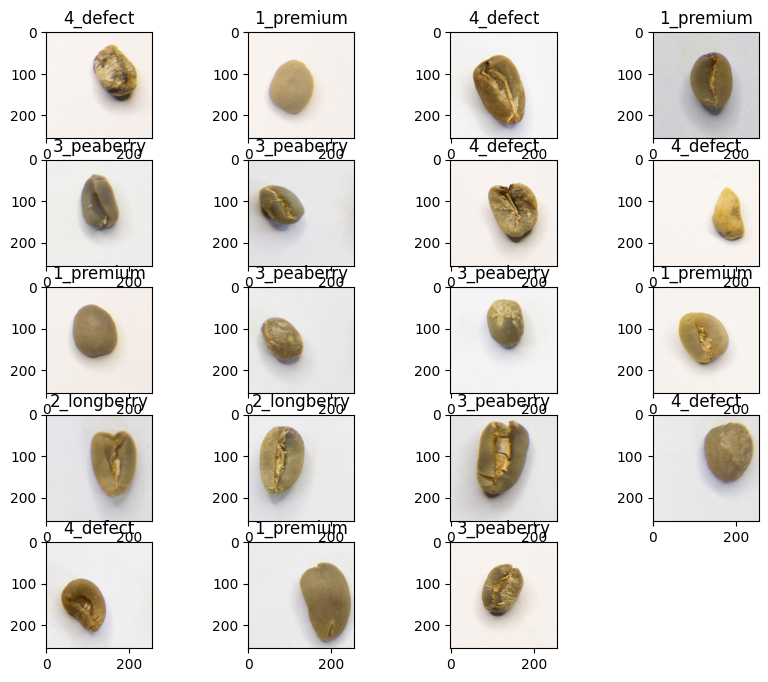

In [ ]:
plt.figure(figsize=(10,8))

i = 1
random_indices = np.random.choice(df.index, size=20, replace=False)
for index in random_indices:
  file_path = df.loc[index, 'file_path']
  labels = df.loc[index, 'label']
  image = Image.open(file_path)
  image_array = np.array(image)
  plt.subplot(5,4,i)
  plt.imshow(image_array)
  plt.title(labels)
  i+=1
  if i>=20: break


plt.show()

**AUGMENTASI DATA**

In [ ]:
#PROSES AUGMENTASI DATA

train_dir = '/content/data_kopi_splitted/train'
val_dir = '/content/data_kopi_splitted/val'

train_datagen = ImageDataGenerator(rescale=(1./255),
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                      batch_size=64,
                                                      class_mode='categorical',
                                                      target_size=(224, 224))

validation_datagen = ImageDataGenerator(rescale=(1./255),
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

validation_generator = validation_datagen.flow_from_directory(directory=val_dir,
                                                                batch_size=64,
                                                                class_mode='categorical',
                                                                target_size=(224, 224))

Found 4800 images belonging to 4 classes.
Found 1600 images belonging to 4 classes.


In [ ]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
#MEMBUAT CALLBACK AGAR TRAINING BERHENTI KETIKA AKURASI YANG DIHARAPKAN SUDAH DIDAPATKAN

class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.90 and logs.get('val_accuracy')>0.90):
            print(" Akurasi sudah mencapai lebih dari 90% maka train dihentikan")
            self.model.stop_training = True

**MODEL TRAINING MACHINE LEARNING**

In [ ]:
model = tf.keras.models.Sequential([
      resnet,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(4, activation='softmax')
      ])

model.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.001, momentum=0.9),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'],)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 23,595,908
Trainable params: 23,542,788
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
model_hist = model.fit(train_generator,
                    epochs=50,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[Callback()])

Epoch 1/50
75/75 [==============================] - 132s 1s/step - loss: 0.7795 - accuracy: 0.6765 - val_loss: 1.5716 - val_accuracy: 0.2500
Epoch 2/50
75/75 [==============================] - 101s 1s/step - loss: 0.3296 - accuracy: 0.8794 - val_loss: 1.8910 - val_accuracy: 0.2500
Epoch 3/50
75/75 [==============================] - 101s 1s/step - loss: 0.2318 - accuracy: 0.9212 - val_loss: 2.0962 - val_accuracy: 0.2500
Epoch 4/50
75/75 [==============================] - 101s 1s/step - loss: 0.1890 - accuracy: 0.9296 - val_loss: 2.2096 - val_accuracy: 0.2331
Epoch 5/50
75/75 [==============================] - 120s 2s/step - loss: 0.1480 - accuracy: 0.9479 - val_loss: 2.4620 - val_accuracy: 0.2531
Epoch 6/50
75/75 [==============================] - 101s 1s/step - loss: 0.1281 - accuracy: 0.9546 - val_loss: 3.3095 - val_accuracy: 0.2500
Epoch 7/50
75/75 [==============================] - 101s 1s/step - loss: 0.1206 - accuracy: 0.9575 - val_loss: 4.3279 - val_accuracy: 0.2500
Epoch 8/50
75

**PLOT HASIL TRAINING**

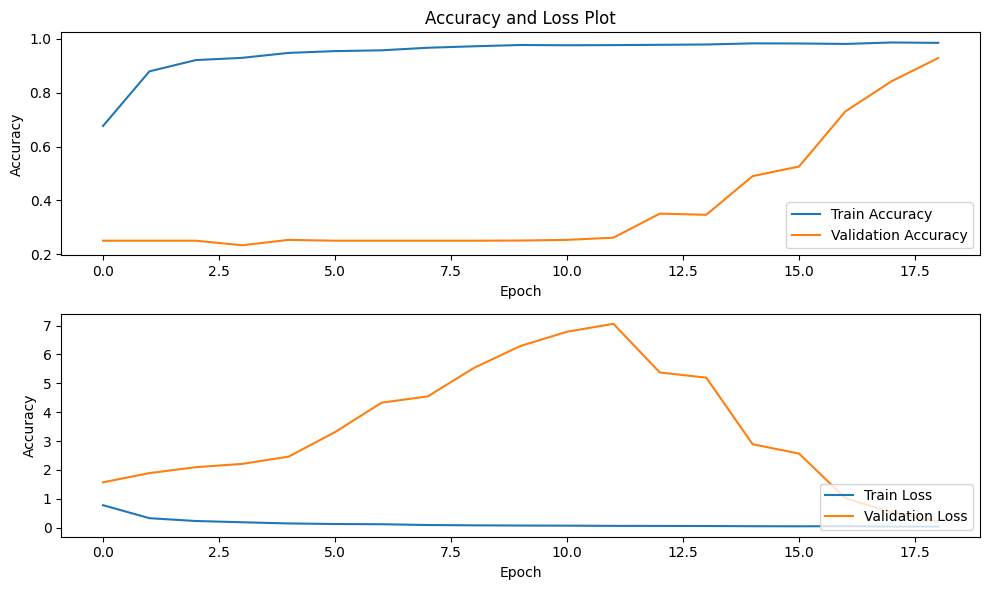

In [ ]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(model_hist.history['accuracy'], label='Train Accuracy')
plt.plot(model_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy and Loss Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(model_hist.history['loss'], label='Train Loss')
plt.plot(model_hist.history['val_loss'], label='Validation Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

**COBA PREDIKSI DATA BARU**

1. Menggunakan File Path

In [ ]:
class_names = np.array(['premium', 'longberry', 'peaberry', 'defect'])

['premium' 'longberry' 'peaberry' 'defect']


In [ ]:
img_path = '/content/test/peaberry/1605.jpg'

image = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))

1/1 [==============================] - 0s 38ms/step


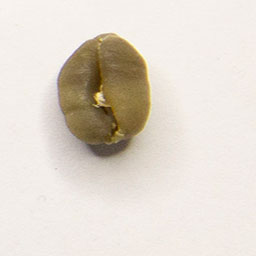

Aktual:  peaberry
Prediksi:  peaberry


In [ ]:
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
input_arr = input_arr.astype('float32') / 255.
predictions = model.predict(input_arr)

predicted_class = np.argmax(predictions, axis=-1)

predicted_class_index = np.argmax(predictions[0])
predicted_class_label = class_names[predicted_class_index]


im = Image.open(img_path)

im.show()
print("Aktual: ", img_path.split('/')[-2])
print("Prediksi: ", predicted_class_label)


2. Menggunakan File Upload

In [ ]:
uploaded = files.upload()
img_path_up = list(uploaded.keys())[0]

image = tf.keras.preprocessing.image.load_img(img_path_up, target_size=(224, 224))

Saving longberry.jpg to longberry.jpg


1/1 [==============================] - 0s 25ms/step


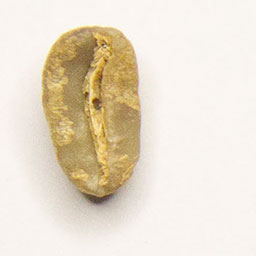

Aktual:  longberry.jpg
Prediksi:  longberry


In [ ]:
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
input_arr = input_arr.astype('float32') / 255.
predictions = model.predict(input_arr)

predicted_class = np.argmax(predictions, axis=-1)

predicted_class_index = np.argmax(predictions[0])
predicted_class_label = class_names[predicted_class_index]


im = Image.open(img_path_up)

im.show()
print("Aktual: ", img_path_up.split('/')[-1]) #masukkan file dengan nama aktual
print("Prediksi: ", predicted_class_label)
os.remove(img_path_up)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model_kopi.tflite', 'wb') as f:
  f.write(tflite_model)